# Bayesian Deep Learning

## Introduction to Bayesian Neural Networks

This tutorial introduces the reader to the concept of Bayesian neural networks. A symbiosis between the extensive research done on neural networks, but where at the same time hyperparameters and "prior" knowledge are encoded in the setup of the weights, and Bayesian analysis, the study of the relation between our preconceptions and their change when confronted with new data. In its simplest form one would take distributions from our favorite package and put them over the weights of the neural network.

<img src="imgs/BayesianNN.png" width="500" height="170" />

As the search for a posterior does then, like in the probabilistic programming tutorial, rely on sampling-heavy routines the embedding of such Bayesian neural network inside of a PPL, such as Turing allows Turing's advanced inference algorithms to sample from the probabilistic model and obtain a posterior. We are at the same time faced with the same dilemma as in the amortized inference example; we need to evaluate our desire for accuracy against the available compute ressources and the desire to reduce the influence of priors' influence on the training outcome.

### Main advantages of Bayesian Neural Networks:

- Ability to include and quantify uncertainties
- Improve robustness against adversarial examples

### Downside of Bayesian Neural Networks:

- Computational cost

For a brief walk through the mathematical formalism, please have a look at [this](https://davidstutz.de/a-short-introduction-to-bayesian-neural-networks/) blog entry. For a much deeper look into the topic feel free to have a look Radford M. Neal's PhD thesis [Bayesian Learning for Neural Networks](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.446.9306&rep=rep1&type=pdf).


### Outline:

**Section 1.** [A First Bayesian Neural Network](#first)

**Section 2.** [Generic Bayesian Neural Networks](#generic)

**Section 3.** [Exercise - Different types of Bayesian Neural Networks](#ex)



In [ ]:
using Turing, Flux, Plots, Random

In [ ]:
# Hide sampling progress
Turing.turnprogress(false);

# Use reverse_diff due to the number of parameters in the neural network
Turing.setadbackend(:reverse_diff);

## 1: A First Bayesian Neural Network <a name="first"></a>

Generate an artificial dataset with its points arranged in a box-like pattern

In [ ]:
# Number of points
N = 80
M = round(Int, N / 4)
Random.seed!(1234)

# Generate artificial data
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
xt1s = Array([[x1s[i] + 0.5; x2s[i] + 0.5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
append!(xt1s, Array([[x1s[i] - 5; x2s[i] - 5] for i = 1:M]))

x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
xt0s = Array([[x1s[i] + 0.5; x2s[i] - 5] for i = 1:M])
x1s = rand(M) * 4.5; x2s = rand(M) * 4.5;
append!(xt0s, Array([[x1s[i] - 5; x2s[i] + 0.5] for i = 1:M]))

# Store all data for later use
xs = [xt1s; xt0s]
ts = [ones(2*M); zeros(2*M)];

Visualize the artificial dataset

In [ ]:
# Plot data points
function plot_data()
    x1 = map(e -> e[1], xt1s)
    y1 = map(e -> e[2], xt1s)
    x2 = map(e -> e[1], xt0s)
    y2 = map(e -> e[2], xt0s)
    
    Plots.scatter(x1, y1, color="red", clim = (0, 1))
    Plots.scatter!(x2, y2, color="blue", clim = (0, 1))
end

plot_data()

### 1.1: Create a neural network with two hidden layers and one output layer

Define a helper function for the training of neural networks and subsequently construct the neural network in Flux

In [ ]:
# Turn a vector into a set of weights and biases
function unpack(nn_params::AbstractVector)
    W1 = reshape(nn_params[1:6], 3, 2);
    b1 = reshape(nn_params[7:9], 3)
    
    W2 = reshape(nn_params[10:15], 2, 3);
    b2 = reshape(nn_params[16:17], 2)
    
    W0 = reshape(nn_params[18:19], 1, 2);
    b0 = reshape(nn_params[20:20], 1)
    return W1, b1, W2, b2, W0, b0
end

# Construct the neural network with Flux and predict its output
function nn_forward(xs, nn_params::AbstractVector)
    W1, b1, W2, b2, W0, b0 = unpack(nn_params)
    nn = Chain(Dense(W1, b1, tanh),
               Dense(W2, b2, tanh),
               Dense(W0, b0, σ))
    return nn(xs)
end;

### 1.2: Build the probabilistic model

Create the probabilistic model encapsulating the Bayesian neural network, where the prior comes from a multivariate normal distribution

In [ ]:
# Create a regularization term and a Gaussian prior variance term
alpha = 0.09
sig = sqrt(1.0 / alpha)

# Specify the probabilistic model
@model bayes_nn(xs, ts) = begin
    # Create the weight and bias vector
    nn_params ~ MvNormal(zeros(20), sig .* ones(20))
    
    # Calculate predictions for the inputs given the weights and biases in theta
    preds = nn_forward(xs, nn_params)
    
    # Observe each prediction
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end;

Perform inference using the Hamiltonian Monte-Carlo algorithm with 5000 epochs

In [ ]:
# Perform inference on the Bayesian neural network
N = 5000
ch = sample(bayes_nn(hcat(xs...), ts), HMC(0.05, 4), N);

Retrieve the posterior values for the weights and biases from the sampled chain

In [ ]:
# Extract weights and biases
theta = ch[:nn_params].value.data;

### 1.3: Maximum a posteriori (MAP) estimation

Find the set of weights, which provided the highest log posterior and subsequently plot the dataset

In [ ]:
plot_data()

# Find index with highest log posterior in the chain
_, i = findmax(ch[:lp].value.data)

# Extract max row value
i = i.I[1]

# Plot posterior distribution
x_range = collect(range(-6, stop=6, length=25))
y_range = collect(range(-6, stop=6, length=25))
Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

Drawn from the MCMC chain the predicted values are returned after the inference

In [ ]:
# Return average predicted value across weights
function nn_predict(x, theta, num)
    mean([nn_forward(x, theta[i, :])[1] for i in 1:10:num])
end;

In [ ]:
# Plot average prediction
plot_data()

n_end = 1500
x_range = collect(range(-6, stop=6, length=25))
y_range = collect(range(-6, stop=6, length=25))
Z = [nn_predict([x, y], theta, n_end)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

Using the ability to animate the sampling process we visualize the change in posterior over time 

In [ ]:
# Plot the evolution of the network's predictive power
n_end = 500

anim = @animate for i=1:n_end
    plot_data()
    Z = [nn_forward([x, y], theta[i, :])[1] for x=x_range, y=y_range]
    contour!(x_range, y_range, Z, title="Iteration $i", clim=(0, 1))
end every 5

gif(anim, "/tmp/jl_ozeq2f.gif", fps=15)

## 2: Generic Bayesian Neural Networks <a name="generic"></a>

We introduce a more general setup of the neural network, which will allow us to change subparts of the network later on in the exercises. The main constraint here is that we are still constrained to purely 'Dense' layers and have to refrain from using more advanced cells in this framework.

### 2.1 More generalized framework

We govern the shape of the entire network through the 'network_shape'. Data is subsequently prepared for training

In [ ]:
# Specify the network architecture made up of 'dense' layers
network_shape = [
    (3, 2, :tanh),
    (2, 3, :tanh),
    (1, 2, :σ)
]

# Regularization, parameter variance & total number of parameters
alpha = 0.09
sig = sqrt(1.0 / alpha)
num_params = sum([i * o + i for (i, o, _) in network_shape])

# Generate a series of vectors given the network shape
function unpack(θ::AbstractVector, network_shape::AbstractVector)
    index = 1
    weights = []
    biases = []
    for layer in network_shape
        rows, cols, _ = layer
        size = rows * cols
        last_index_w = size + index - 1
        last_index_b = last_index_w + rows
        push!(weights, reshape(θ[index:last_index_w], rows, cols))
        push!(biases, reshape(θ[last_index_w + 1:last_index_b], rows))
        index = last_index_b + 1
    end
    return weights, biases
end

# Generate the neural network given a shape and return a prediction
function nn_forward(x, θ::AbstractVector, network_shape::AbstractVector)
    weights, biases = unpack(θ, network_shape)
    layers = []
    for i in eachindex(network_shape)
        push!(layers, Dense(weights[i],
                biases[i],
                eval(network_shape[i][3])))
    end
    nn = Chain(layers...)
    return nn(x)
end

# General Turing specification for a BNN
@model bayes_nn(xs, ts, network_shape, num_params) = begin
    θ ~ MvNormal(zeros(num_params), sig .* ones(num_params))
    preds = nn_forward(xs, θ, network_shape)
    for i = 1:length(ts)
        ts[i] ~ Bernoulli(preds[i])
    end
end

# Set the backend
Turing.setadbackend(:reverse_diff);

Use Hamiltonian Monte-Carlo to sample from the probabilistic neural network model and arrive at a valid posterior

In [ ]:
# Perform inference
num_samples = 10000
ch2 = sample(bayes_nn(hcat(xs...), ts, network_shape, num_params), HMC(0.05, 4), num_samples);

Make predictions based on the network shape

In [ ]:
# Make predictions based on network shape
function nn_predict(x, theta, num, network_shape)
    mean([nn_forward(x, theta[i, :], network_shape)[1] for i in 1:10:num])
end;

# Extract θ from the sampled chain
params2 = ch2[:θ].value.data;

Plot the results

In [ ]:
# Plot the prediction
plot_data()

x_range = collect(range(-6, stop=6, length=25))
y_range = collect(range(-6, stop=6, length=25))
Z = [nn_predict([x, y], params2, length(ch2), network_shape)[1] for x=x_range, y=y_range]
contour!(x_range, y_range, Z)

## 3: Exercise - Different types of Bayesian Neural Networks <a name="ex"></a>

- Experiment with deep Bayesian neural networks
    - How does the inference engine scale throughout changes to the neural network?
- Experiment with different kinds of noise by rewriting the probabilistic model using the above examples and Turing's [library](https://github.com/TuringLang/Turing.jl/blob/master/src/stdlib/distributions.jl).
    - Which other probability [distributions](https://github.com/JuliaStats/Distributions.jl) might also be of interest?
- How many samples do I need across networks to arrive at an expressive posterior?
- Change the inference algorithm employed by Turing to a variational inference based one and experiment with its behaviour.

## Bayesian Differential Equations

In [16]:
using Turing, Distributions, DataFrames, DifferentialEquations, DiffEqSensitivity
using MCMCChains, Plots, StatsPlots

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
┌ Info: Precompiling NamedArrays [86f7a689-2022-50b4-a561-43c23ac3c673]
└ @ Base loading.jl:1273


Julia has over the past few years developed a vibrant ecosystem around differential equations and the integration with neural networks through the posing of problems as adjoints. This is quite illustrative for our purposes, as we are essentially constructing artificial forward-problems using the [DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl) package and then using Turing's abilities to bring the power of Bayesian inference to bear.

This section is modeled after the [Bayesian differential equations](https://turing.ml/dev/tutorials/10-bayesiandiffeq/) tutorial of Turing. A further reference to wade deeper into the connection of differential equations, probabilistic programming and machine learning is the [DiffEqFlux.jl](https://diffeqflux.sciml.ai/dev/) documentation.

We will begin by defining the Lota-Volterra equations, two coupled first-order nonlinear differential equations, which can be for example be used to describe species dynamics in a biological system.

In [15]:
import Pkg; Pkg.add("StatsPlots")

 Resolving package versions...
  Updating `~/.julia/environments/v1.3/Project.toml`
  [f3b207a7] + StatsPlots v0.14.6
  Updating `~/.julia/environments/v1.3/Manifest.toml`
  [13072b0f] + AxisAlgorithms v1.0.0
  [aaaa29a8] + Clustering v0.14.1
  [e7dc6d0d] + DataValues v0.4.13
  [a98d9a8b] + Interpolations v0.12.10
  [5ab0869b] + KernelDensity v0.5.1
  [6f286f6a] + MultivariateStats v0.7.0
  [b8a86587] + NearestNeighbors v0.4.6
  [429524aa] + Optim v0.22.0
  [85a6dd25] + PositiveFactorizations v0.2.3
  [c84ed2f1] + Ratios v0.4.0
  [f3b207a7] + StatsPlots v0.14.6
  [ab02a1b2] + TableOperations v0.2.1
  [efce3f68] + WoodburyMatrices v0.5.2


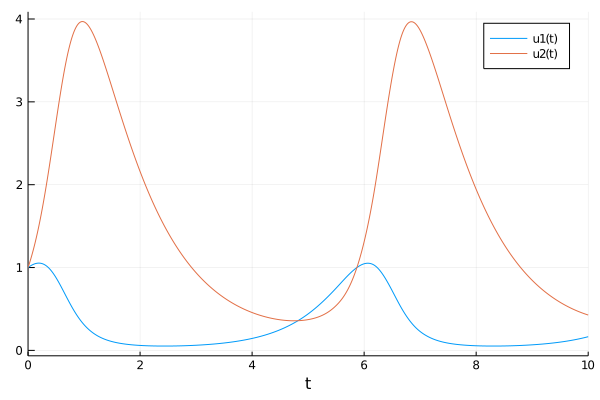

In [18]:
function lotka_volterra(du, u, p, t)
    x, y = u
    α, β, δ, γ = p
    du[1] = dx = (α - β*y)x
    du[2] = dy = (δ*x - γ)y
end

p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0, 1.0]
prob = ODEProblem(lotka_volterra, u0, (0.0, 10.0), p)
sol = solve(prob, Tsit5())
plot(sol)

We can then generate data for the parameter estimation from simulation data, where we specify the time-interval in which data is stored

In [19]:
odedata = Array(solve(prob, Tsit5(), saveat=0.1))

2×101 Array{Float64,2}:
 1.0  1.03981  1.05332  1.03247  0.972908  …  0.133965  0.148601  0.165247
 1.0  1.22939  1.52387  1.88714  2.30908      0.476902  0.450153  0.426924

`DiffEqBayes.jl` now allows us to estimate the parameters of differential equations we are able to pose using Bayesian methods, i.e. techniques from probabilistic programming systems. In doing so we will use the `Turing.jl` backend to perform a Bayesian estimation of the differential equation problem we previously specified.

The package furthermore provides interfaces to `Stan`, `DynamicHMC.jl` and `ApproxBayes.jl` for Approximate Bayesian Computation (ABC).

In [22]:
using DiffEqBayes

┌ Info: Precompiling DiffEqBayes [ebbdde9d-f333-5424-9be2-dbf1e9acfb5e]
└ @ Base loading.jl:1273


In [23]:
t = 0:0.1:10.0
priors = [truncated(Normal(1.5, 0.5), 0.5, 2.5), truncated(Normal(1.2, 0.5), 0, 2), truncated(Normal(3.0, 0.5), 1, 4), truncated(Normal(1.0, 0.5), 0, 2)]
bayesian_result_turing = turing_inference(prob, Tsit5(), t, odedata, priors, num_samples=10_000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: Automatic dt set the starting dt as NaN, causing instability.
└ @ OrdinaryDiffEq /home/lpaehler/.julia/packages/OrdinaryDiffEq/tVsYE/src/solve.jl:456
┌ Warning: NaN dt detected. Likely a NaN value in the state, parameters, or derivative value caused this outcome.
└ @ DiffEqBase /home/lpaehler/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:323
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected d

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = 

Object of type Chains, with data of type 9000×17×1 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = theta[1], theta[2], theta[3], theta[4], σ[1]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
    theta[1]  0.9097  0.2712    0.0029  0.0031  6018.8115  1.0000
    theta[2]  1.8512  0.1199    0.0013  0.0016  5028.6244  1.0001
    theta[3]  2.5842  0.3569    0.0038  0.0059  3981.8101  1.0001
    theta[4]  0.1240  0.0237    0.0002  0.0004  4188.6165  1.0000
        σ[1]  0.8742  0.0435    0.0005  0.0006  6648.6558  1.0008

Quantiles
  parameters    2.5%   25.0%   50.0%  

Plotting the chains to converged to the true posterior

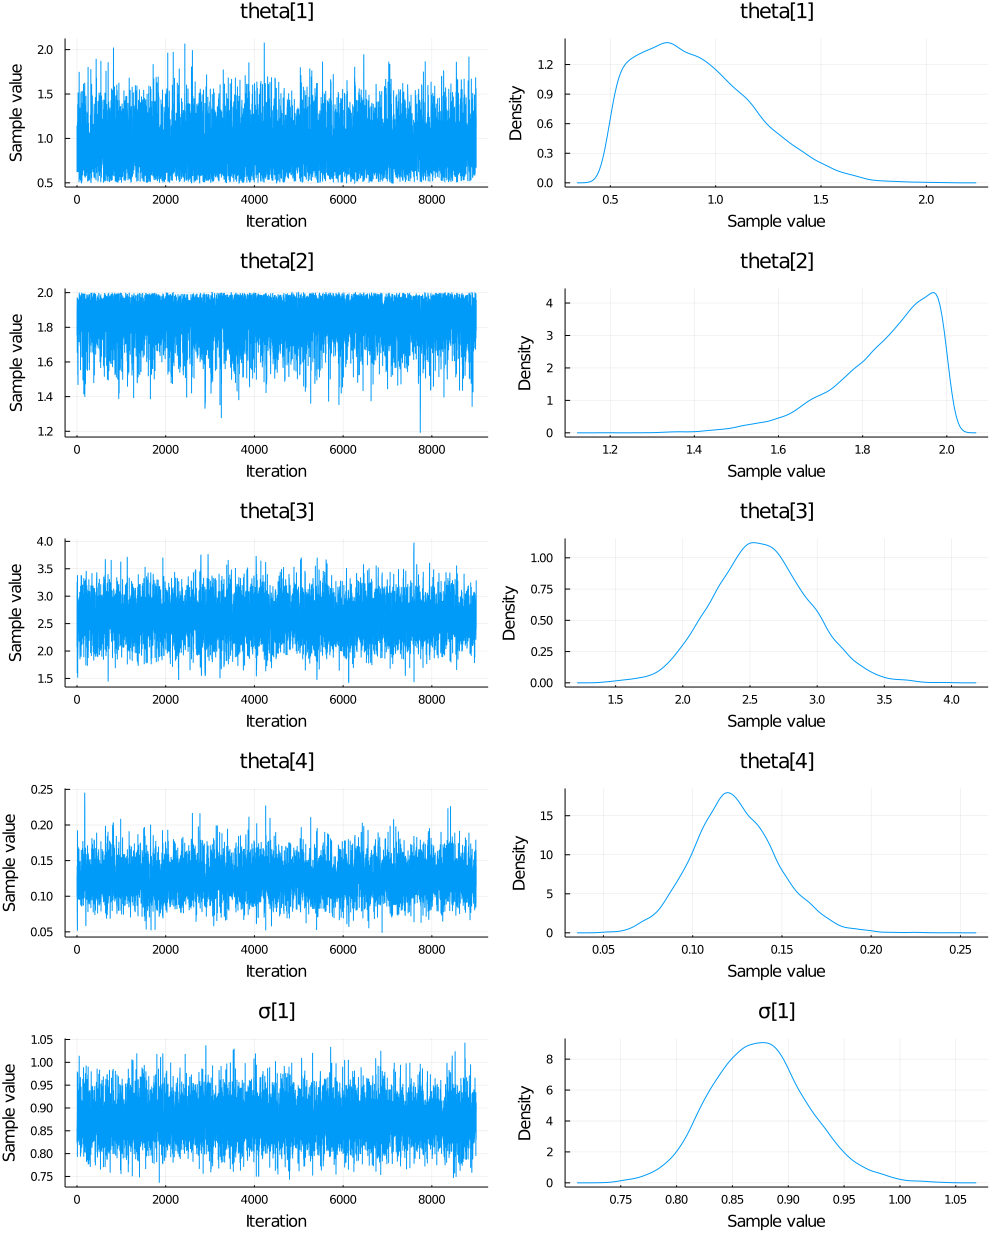

In [24]:
plot(bayesian_result_turing)

### A Turing-Native Workflow

Benefitting from the composability of Julia, we will now define our function as a `model` inside of Turing and show the same kind of analysis by composing Turing and DifferentialEquations.

Rewrite the Lotka Volterra as a parameter estimation problem inside of Turing.

In [26]:
Turing.setadbackend(:forwarddiff)

@model function fit_lotka_volterra(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)
    
    p = [α, β, γ, δ]
    prob = ODEProblem(lotka_volterra, u0, (0.0, 10.0), p)
    predicted = solve(prob, Tsit5(), saveat=0.1)
    
    for i = 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ)
    end
end

model = fit_lotka_volterra(odedata)
chain = sample(model, NUTS(.65), 10000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47


Object of type Chains, with data of type 9000×17×1 Array{Float64,3}

Iterations        = 1:9000
Thinning interval = 1
Chains            = 1
Samples per chain = 9000
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse        ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ─────────  ──────
           α  1.5002  0.0062    0.0001  0.0001  2945.4630  1.0003
           β  1.0000  0.0038    0.0000  0.0001  3031.5633  1.0003
           γ  2.9991  0.0047    0.0000  0.0001  4556.9492  1.0002
           δ  0.9998  0.0034    0.0000  0.0001  2896.8716  1.0004
           σ  0.0151  0.0011    0.0000  0.0000  4074.2544  0.9999

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──

Automatic differentiation capability is provided by the `DifferentialEquations.jl`, where automatic differentiation was briefly scratched upon in the previous lecture, as well as sensitvity analysis. Wrapping around our scientific simulator, to provide automatic differentiation capability we can basically just switch in our simulator for the differential equations example. Sensitivity analysis is provided either by forward sensitivity analysis or by adjoint sensitivity analysis.

Differential equations sensitivity analysis backend is compatible with the following automatic differentiation backends `ReverseDiff`, `Tracker`, or `Zygote`. Adjoints reach their peak performance on more than 100 parameters, as Julia incurs a compilation overhead, which can then be amortized in a better fashion.

In [33]:
Turing.setadbackend(:reversediff)
@model function fit_lotka_volterra(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)
    p = [α, β, γ, δ]
    prob = ODEProblem(lotka_volterra, u0, (0.0, 10.0), p)
    predicted = solve(prob, saveat=0.1)
    for i = 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ)
    end
end;

model = fit_lotka_volterra(odedata)
chain = sample(model, NUTS(.65), 1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9

Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  2.3210  0.1045    0.0047  0.0050  144.1799  1.0000
           β  1.5399  0.0979    0.0044  0.0055  255.4553  0.9981
           γ  3.1273  0.2038    0.0091  0.0126  219.7536  1.0053
           δ  1.8399  0.0792    0.0035  0.0053  137.0410  0.9988
           σ  0.8628  0.0401    0.0018  0.0015  437.3882  0.9980

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

Exploiting the sensitivity analysis capabilities by specifying the sensitivity analysis algorithm in `sensealg` with the `InterpolatingAdjoint` method. The other provided alternative sensitivity analysis methods are:

* `ForwardSensitivity` Continuous Forward Sensitivity Analysis
* `ForwardDiffSensitivity` Discrete Forward Sensitivity Analysis
* `BacksolveAdjoint` Adjoint Sensitivity Analysis using backwards solutions
* `InterpolatingAdjoint` Adjoint Sensitivity Analysis based on interpolation of the forward solution
* `QuadratureAdjoint` Adjoint Sensitivity Analysis based on a post-ODE quadrature
* `ReverseDiffAdjoint` Discrete Adjoint Sensitivity Analysis using the `ReverseDiff.jl` tracing-based AD
* `ZygoteAdjoint` Discrete Adjoint Sensitivity Analysis using the `Zygote.jl` source-to-source AD
* `TrackerAdjoint` Discrete Adjoint Sensitivity Analysis using the `Tracker.jl` tracing-based AD
* `SensitivityADPassThrough` Sensitivity AD throught the solve function ignoring all other definitions.

In [34]:
@model function fit_lotka_volterra(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)
    p = [α, β, γ, δ]
    prob = ODEProblem(lotka_volterra, u0, (0.0, 10.0), p)
    predicted = solve(prob, saveat=0.1, sensealg=InterpolatingAdjoint(autojacvec=ReverseDiffVJP(true)))
    for i = 1:length(predicted)
        data[:, i] ~ MvNormal(predicted[i], σ)
    end
end

model = fit_lotka_volterra(odedata)
@time chain = sample(model, NUTS(.65), 1000)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629


1077.667985 seconds (17.89 G allocations: 627.679 GiB, 11.86% gc time)


Object of type Chains, with data of type 500×17×1 Array{Float64,3}

Iterations        = 1:500
Thinning interval = 1
Chains            = 1
Samples per chain = 500
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = α, β, γ, δ, σ

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse       ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ────────  ──────
           α  1.5012  0.0061    0.0003  0.0004  184.6568  0.9984
           β  1.0007  0.0038    0.0002  0.0002  185.6245  0.9985
           γ  2.9985  0.0042    0.0002  0.0002  351.6463  0.9991
           δ  0.9993  0.0033    0.0001  0.0002  184.1359  0.9982
           σ  0.0151  0.0010    0.0000  0.0001  194.8944  0.9980

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ────

Using the stochastic differential equation form of the Lotka Volterra equations we can then really explore the randomness of our generative model

In [35]:
function lotka_volterra_noise(du, u, p, t)
    du[1] = p[5]*u[1]
    du[2] = p[6]*u[2]
end
p = [1.5, 1.0, 3.0, 1.0, 0.3, 0.3]
prob= SDEProblem(lotka_volterra, lotka_volterra_noise, u0, (0.0, 10.0), p)

SDEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 1.0]

Which we then solve repeatedly to really explore the stochasticity

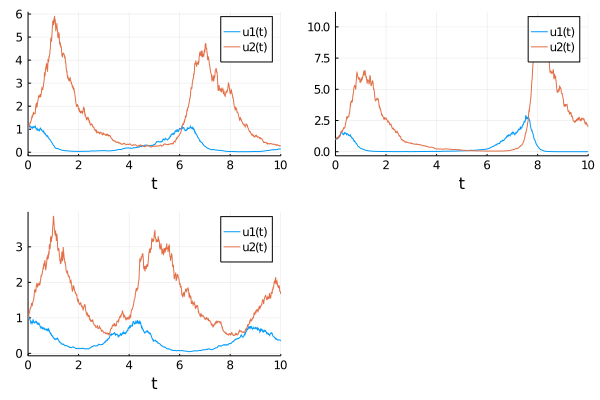

In [36]:
sol = solve(prob, saveat=0.01)
p1 = plot(sol)
sol = solve(prob, saveat=0.01)
p2 = plot(sol)
sol = solve(prob, saveat=0.01)
p3 = plot(sol)
plot(p1, p2, p3)

Running the model for 500 trajectories, we can then use `MonteCarloSummary` to get an overview of the results

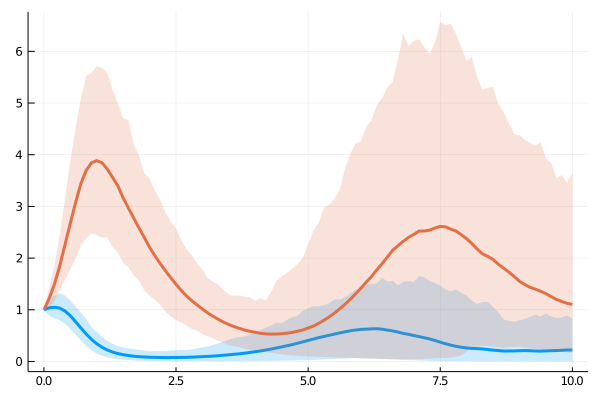

In [37]:
sol = solve(EnsembleProblem(prob), SRIW1(), saveat=0.1, trajectories=500)
summ = MonteCarloSummary(sol)
plot(summ)

In [38]:
Threads.nthreads()

8

We then extract the means from the generated trajectories

In [43]:
using DiffEqBase.EnsembleAnalysis
averagedata = Array(timeseries_steps_mean(sol))

2×101 Array{Float64,2}:
 1.0  1.03948  1.04939  1.03227  0.976139  …  0.217034  0.222176  0.222598
 1.0  1.21818  1.4955   1.84922  2.2608       1.15979   1.12575   1.10431 

For which we can then do the stochastic differential equations parameter estimation using Turing

In [45]:
Turing.setadbackend(:forwarddiff)

@model function fit_lotka_volterra(data)
    σ ~ InverseGamma(2, 3)
    α ~ truncated(Normal(1.5, 0.5), 0.5, 2.5)
    β ~ truncated(Normal(1.2, 0.5), 0, 2)
    γ ~ truncated(Normal(3.0, 0.5), 1, 4)
    δ ~ truncated(Normal(1.0, 0.5), 0, 2)
    ϕ1 ~ truncated(Normal(1.2, 0.5), 0.1, 1)
    ϕ2 ~ truncated(Normal(1.2, 0.5), 0.1, 1)

    p = [α, β, γ, δ, ϕ1, ϕ2]
    prob = SDEProblem(lotka_volterra, lotka_volterra_noise, u0, (0.0, 10.0), p)
    ensemble_predicted = solve(EnsembleProblem(prob), SRIW1(), saveat=0.1, trajectories=500)
    predicted_means = timeseries_steps_mean(ensemble_predicted)
    
    for i = 1:length(predicted_means)
        data[:, i] ~ MvNormal(predicted_means[i], σ)
    end
end;

model = fit_lotka_volterra(averagedata)
chain = sample(model, NUTS(.65), 500)

┌ Info: Found initial step size
│   ϵ = 0.2
└ @ Turing.Inference /home/lpaehler/.julia/packages/Turing/GMBTf/src/inference/hmc.jl:629
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /home/lpaehler/.julia/packages/AdvancedHMC/P9wqk/src/hamiltonian.jl:47
┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/lpaehler/.julia/packages/DiffEqBase/T5smF/src/integrator_interface.jl:343


BoundsError: BoundsError: attempt to access 55-element Array{Array{ForwardDiff.Dual{ForwardDiff.Tag{Turing.Core.var"#f#7"{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},DynamicPPL.Model{var"###evaluator#1147",(:data,),Tuple{Array{Float64,2}},(),DynamicPPL.ModelGen{var"###generator#1148",(:data,),(),Tuple{}}},DynamicPPL.Sampler{NUTS{Turing.Core.ForwardDiffAD{40},(),AdvancedHMC.DiagEuclideanMetric},Turing.Inference.HMCState{DynamicPPL.VarInfo{NamedTuple{(:σ, :α, :β, :γ, :δ, :ϕ1, :ϕ2),Tuple{DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:σ,Tuple{}},Int64},Array{InverseGamma{Float64},1},Array{DynamicPPL.VarName{:σ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:α,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:α,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:β,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:β,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:γ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:γ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:δ,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:δ,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ1,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ1,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}},DynamicPPL.Metadata{Dict{DynamicPPL.VarName{:ϕ2,Tuple{}},Int64},Array{Truncated{Normal{Float64},Continuous,Float64},1},Array{DynamicPPL.VarName{:ϕ2,Tuple{}},1},Array{Float64,1},Array{Set{DynamicPPL.Selector},1}}}},Float64},AdvancedHMC.NUTS{AdvancedHMC.MultinomialTS,AdvancedHMC.GeneralisedNoUTurn,AdvancedHMC.Leapfrog{Float64},Float64},AdvancedHMC.Adaptation.StanHMCAdaptor{AdvancedHMC.Adaptation.WelfordVar{Float64,Array{Float64,1}},AdvancedHMC.Adaptation.NesterovDualAveraging{Float64}},AdvancedHMC.PhasePoint{Array{Float64,1},AdvancedHMC.DualValue{Float64,Array{Float64,1}}}}}},Float64},Float64,7},1},1} at index [56]

-> Numerical solution is unstable!

## Exercise - Generalize from Differential Equations to Simulators

* Consider how the outlines of the differential equations example can be generalized to general simulators

    * Which interfaces do you need to implement?
    
    * How would one be able to interact with the automatic differentiation backend and provide gradients?